In [2]:
import math
import time
import torch
import requests
import matplotlib.pyplot as plt
# Select device (GPU if available, else CPU)
import torch.nn as nn

from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer
from collections import Counter

## Dataset,Tokenization and Preprocessing

In [3]:
# Parameters
MAX_VOCAB_SIZE = 10000
MIN_FREQ = 5
SEQ_LENGTH = 8
BATCH_SIZE = 64


# Load WikiText-2 using Hugging Face datasets
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_texts = dataset["train"]["text"]
val_texts = dataset["validation"]["text"]
test_texts = dataset["test"]["text"]

# Add <BOS> and <EOS> around each sentence
def preprocess_lines(lines):
    return ["<BOS> " + line.strip() + " <EOS>" for line in lines if line.strip() != ""]

train_text = " ".join(preprocess_lines(train_texts))
val_text = " ".join(preprocess_lines(val_texts))
test_text = " ".join(preprocess_lines(test_texts))

# Load GPT2 tokenizer and add special tokens
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({
    "pad_token": "<PAD>",
    "unk_token": "<UNK>",
    "bos_token": "<BOS>",
    "eos_token": "<EOS>"
})

# Tokenize with chunking
def chunk_text(text, chunk_size=1024):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

def tokenize_with_chunking(text, chunk_size=1024):
    tokens = []
    for chunk in chunk_text(text, chunk_size):
        tokens.extend(tokenizer(chunk, truncation=False)["input_ids"])
    return tokens

train_tokens = tokenize_with_chunking(train_text)
val_tokens = tokenize_with_chunking(val_text)
test_tokens = tokenize_with_chunking(test_text)

# Build token frequency counter
token_counts = Counter(train_tokens)

# Print most common rare tokens
rare_tokens = [tok for tok, count in token_counts.items() if count < MIN_FREQ]
rare_tokens_sorted = sorted(rare_tokens, key=lambda t: -token_counts[t])[:30]

print("\nMost common rare tokens (replaced with <UNK>):")
for tok_id in rare_tokens_sorted:
    print(f"{tok_id}: '{tokenizer.decode([tok_id])}' — {token_counts[tok_id]} occurrences")

# Get most frequent tokens
most_common_tokens = [
    token for token, count in token_counts.items() if count >= MIN_FREQ
]
most_common_tokens = sorted(most_common_tokens, key=lambda x: -token_counts[x])

# Reserve room for 4 special tokens
num_specials = 4
trimmed_common = most_common_tokens[:MAX_VOCAB_SIZE - num_specials]

# Get special token IDs
special_token_ids = [
    tokenizer.pad_token_id,
    tokenizer.unk_token_id,
    tokenizer.bos_token_id,
    tokenizer.eos_token_id,
]

# Final vocab list: specials first + top remaining

# Start with special tokens
vocab_set = set()
vocab_list = []

# Add specials first
for tok in special_token_ids:
    if tok not in vocab_set:
        vocab_list.append(tok)
        vocab_set.add(tok)

# Then fill in from most frequent tokens
for tok in most_common_tokens:
    if tok not in vocab_set:
        vocab_list.append(tok)
        vocab_set.add(tok)
    if len(vocab_list) >= MAX_VOCAB_SIZE:
        break

# Token → vocab index mapping
token_id_to_index = {tok_id: idx for idx, tok_id in enumerate(vocab_list)}
unk_index = token_id_to_index[tokenizer.unk_token_id]
vocab_size = len(vocab_list)

print(f"\n Final vocabulary size: {vocab_size} (including specials)")
print(" \n Special token indices:")
for i, tid in enumerate(special_token_ids):
    print(f"   {tokenizer.decode([tid]):<5} → {token_id_to_index[tid]}")


# Print vocabulary
print("\nVocabulary:")
for token_id in most_common_tokens[:50]:
    print(f"{token_id}: {tokenizer.decode([token_id])}", end = "")

# Remap tokens using new vocab
def remap_tokens(token_list):
    return [token_id_to_index.get(tok, unk_index) for tok in token_list]

def create_sequences(token_list):
    X, y = [], []
    remapped = remap_tokens(token_list)
    for i in range(len(remapped) - SEQ_LENGTH):
        input_seq = remapped[i:i+SEQ_LENGTH]
        target = remapped[i+SEQ_LENGTH]
        X.append(input_seq)
        y.append(target)
    return X, y

# Prepare all datasets
X_train, y_train = create_sequences(train_tokens)
X_val, y_val = create_sequences(val_tokens)
X_test, y_test = create_sequences(test_tokens)



Most common rare tokens (replaced with <UNK>):
44444: 'ヴァ' — 4 occurrences
30193: ' Battlefield' — 4 occurrences
22134: ' Azure' — 4 occurrences
35094: ' Gau' — 4 occurrences
6574: ' HP' — 4 occurrences
8655: ' Table' — 4 occurrences
22763: ' Shock' — 4 occurrences
23432: ' Ready' — 4 occurrences
28602: ' erase' — 4 occurrences
35731: ' traitor' — 4 occurrences
30552: ' Ramsey' — 4 occurrences
38489: ' layouts' — 4 occurrences
22849: ' cooperative' — 4 occurrences
23447: ' Wish' — 4 occurrences
43266: 'も' — 4 occurrences
28938: '�' — 4 occurrences
35183: ' scant' — 4 occurrences
18068: ' DLC' — 4 occurrences
32013: ' finalized' — 4 occurrences
22633: ' Eisen' — 4 occurrences
33891: ' Shinji' — 4 occurrences
35763: ' Hirosh' — 4 occurrences
46788: '��' — 4 occurrences
34402: '�' — 4 occurrences
20046: '�' — 4 occurrences
32316: ' appropriated' — 4 occurrences
8337: 'ockey' — 4 occurrences
1750: ' sever' — 4 occurrences
37968: ' procession' — 4 occurrences
24989: ' rumor' — 4 occurrence

<UNK> count in Train: 1531464 (7.8081%)
<UNK> count in Validation: 189969 (9.3688%)
<UNK> count in Test: 226605 (9.7514%)


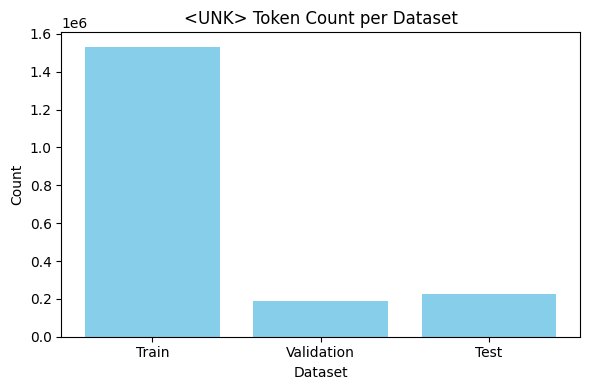

In [3]:
# Count <UNK> tokens in datasets
def count_unk(sequences, label):
    flat = [tok for seq in sequences for tok in seq]
    count = sum(tok == unk_index for tok in flat)
    print(f"<UNK> count in {label}: {count} ({count / len(flat):.4%})")
    return count

# Visualize distribution of <UNK>
unk_counts = {
    "Train": count_unk(X_train, "Train"),
    "Validation": count_unk(X_val, "Validation"),
    "Test": count_unk(X_test, "Test")
}

plt.figure(figsize=(6, 4))
plt.bar(unk_counts.keys(), unk_counts.values(), color="skyblue")
plt.title("<UNK> Token Count per Dataset")
plt.ylabel("Count")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()

In [4]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Debug prints
print(f"Tokenizer full vocab size: {tokenizer.vocab_size}")
print(f"Training examples: {len(train_data)}")
print(f"Validation examples: {len(val_data)}")
print(f"Test examples: {len(test_data)}")

Tokenizer full vocab size: 50257
Training examples: 2451710
Validation examples: 253459
Test examples: 290478


In [5]:
# OOV Coverage Stats
def calculate_oov_rate(tokens, name):
    remapped = remap_tokens(tokens)
    total = len(remapped)
    oov_count = sum(1 for tok in remapped if tok == unk_index)
    print(f"{name} OOV rate: {oov_count}/{total} = {oov_count / total:.4f}")

calculate_oov_rate(val_tokens, "Validation")
calculate_oov_rate(test_tokens, "Test")

Validation OOV rate: 23747/253467 = 0.0937
Test OOV rate: 28326/290486 = 0.0975


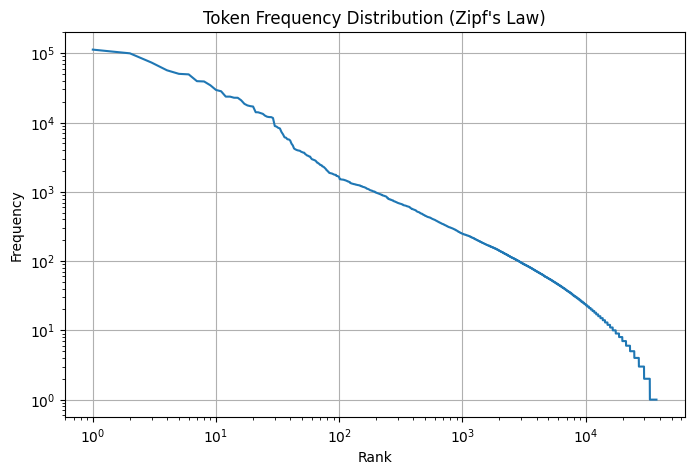

In [6]:
# Plot Zipf's Law
token_freqs = [count for _, count in token_counts.most_common()]
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(token_freqs) + 1), token_freqs)
plt.title("Token Frequency Distribution (Zipf's Law)")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

## Baseline Next-Token Prediction Model

In [7]:

class FeedForwardLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dims=[256, 128], combine_method="concat"):
        """
        Feed-forward language model for next-token prediction.
        :param vocab_set: size of vocabulary (for output layer and embedding).
        :param embed_dim: dimension of word embeddings.
        :param hidden_dims: list with sizes of hidden layers.
        :param combine_method: "concat" or "average" embeddings to combine the 8 tokens.
        """
        super(FeedForwardLM, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.combine_method = combine_method
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        if combine_method == "concat":
            self.combined_dim = embed_dim * 8
        elif combine_method == "average":
            self.combined_dim = embed_dim
        else:
            raise ValueError("combine_method must be 'concat' or 'average'")

        self.fc1 = nn.Linear(self.combined_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.out = nn.Linear(hidden_dims[1], vocab_size)

    def forward(self, x):
        """
        Forward pass for next-token prediction.
        :param x: Tensor of shape (batch_size, 8) with token indices for context.
        :return: Tensor of shape (batch_size, vocab_set) with logits for next token.
        """
        # x shape: [batch, seq_len=8]
        embed = self.embedding(x)           # [batch, 8, embed_dim]
        if self.combine_method == "concat":
            # Flatten the 8 embeddings into one vector
            batch_size = embed.size(0)
            x_comb = embed.view(batch_size, -1)    # [batch, 8*embed_dim]
        else:  # average
            x_comb = embed.mean(dim=1)             # [batch, embed_dim]
        # Feed-forward layers with ReLU activations
        x = torch.relu(self.fc1(x_comb))           # [batch, 256]
        x = torch.relu(self.fc2(x))                # [batch, 128]
        logits = self.out(x)                       # [batch, vocab_set] (raw scores for next token)
        return logits

# Instantiate the baseline model
baseline_model = FeedForwardLM(vocab_size = vocab_size, embed_dim=128, hidden_dims=[256, 128], combine_method="concat")
print(baseline_model)


FeedForwardLM(
  (embedding): Embedding(10000, 128)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10000, bias=True)
)


In [8]:
# Function to evaluate on validation or test set (returns perplexity)
def evaluate_perplexity(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)  # [batch, vocab_size]
            # Compute sum of negative log-likelihood loss for this batch
            loss = criterion(outputs, targets)
            # Multiply batch loss by number of items for averaging later
            total_loss += loss.item() * targets.size(0)
            total_count += targets.size(0)
    # Calculate perplexity: exp(total_loss/total_count)
    avg_loss = total_loss / total_count
    ppl = math.exp(avg_loss)
    model.train()
    return ppl

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
baseline_model.to(device)

# Loss function and optimizers for each model
criterion = nn.CrossEntropyLoss()
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

# Training parameters
EPOCHS = 5  # number of epochs
log_interval = 200  # how often to print training loss

Using device: cpu


Epoch 1 | Batch 200/38308 | Avg Loss: 6.8827
Epoch 1 | Batch 400/38308 | Avg Loss: 6.4381
Epoch 1 | Batch 600/38308 | Avg Loss: 6.3507
Epoch 1 | Batch 800/38308 | Avg Loss: 6.3510
Epoch 1 | Batch 1000/38308 | Avg Loss: 6.3026
Epoch 1 | Batch 1200/38308 | Avg Loss: 6.2354
Epoch 1 | Batch 1400/38308 | Avg Loss: 6.2004
Epoch 1 | Batch 1600/38308 | Avg Loss: 6.1988
Epoch 1 | Batch 1800/38308 | Avg Loss: 6.1773
Epoch 1 | Batch 2000/38308 | Avg Loss: 6.0740
Epoch 1 | Batch 2200/38308 | Avg Loss: 6.0847
Epoch 1 | Batch 2400/38308 | Avg Loss: 6.1097
Epoch 1 | Batch 2600/38308 | Avg Loss: 6.0857
Epoch 1 | Batch 2800/38308 | Avg Loss: 6.0721
Epoch 1 | Batch 3000/38308 | Avg Loss: 6.0293
Epoch 1 | Batch 3200/38308 | Avg Loss: 6.0662
Epoch 1 | Batch 3400/38308 | Avg Loss: 5.9976
Epoch 1 | Batch 3600/38308 | Avg Loss: 5.9522
Epoch 1 | Batch 3800/38308 | Avg Loss: 5.9879
Epoch 1 | Batch 4000/38308 | Avg Loss: 5.9373
Epoch 1 | Batch 4200/38308 | Avg Loss: 5.8997
Epoch 1 | Batch 4400/38308 | Avg Loss:

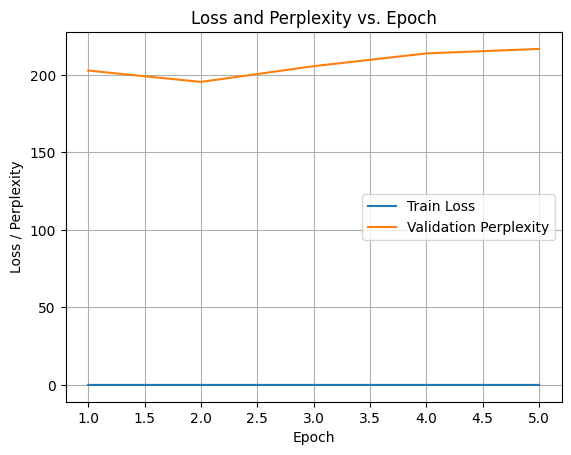

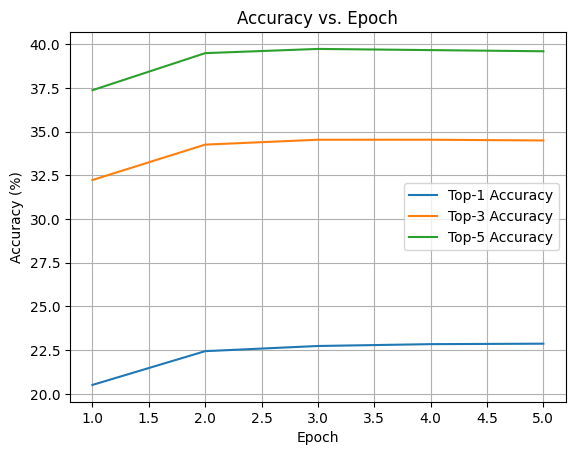

,Epoch,Train Loss,Val Perplexity,Top-1 Acc,Top-3 Acc,Top-5 Acc
0,1,0.014987,202.775295,20.512336,32.232646,37.370040
1,2,0.014710,195.458068,22.443682,34.256947,39.489214
2,3,0.014806,205.603069,22.739272,34.536507,39.730882
3,4,0.014572,213.834043,22.844464,34.537037,39.662807
4,5,0.014690,216.727841,22.871261,34.494700,39.596771


In [10]:

# Training loop with metric tracking
train_losses = []
val_losses = []
top1_accuracies = []
top3_accuracies = []
top5_accuracies = []

for epoch in range(1, EPOCHS+1):
    model = baseline_model
    optimizer = baseline_optimizer
    
    model.train()
    total_loss = 0.0
    correct_top1 = 0
    correct_top3 = 0
    correct_top5 = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader, start=1):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)  # [batch, vocab_size]
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Accuracy computations
        _, pred = outputs.topk(5, dim=1)
        targets = targets.view(-1, 1)
        correct = pred.eq(targets)
        correct_top1 += correct[:, :1].sum().item()
        correct_top3 += correct[:, :3].sum().item()
        correct_top5 += correct[:, :5].sum().item()
        total += targets.size(0)

        if batch_idx % log_interval == 0:
            avg_loss = total_loss / log_interval
            print(f"Epoch {epoch} | Batch {batch_idx}/{len(train_loader)} | Avg Loss: {avg_loss:.4f}")
            total_loss = 0.0

    epoch_loss = total_loss / len(train_loader)
    train_losses.append(epoch_loss)
    top1_accuracies.append(100. * correct_top1 / total)
    top3_accuracies.append(100. * correct_top3 / total)
    top5_accuracies.append(100. * correct_top5 / total)

    val_ppl = evaluate_perplexity(model, val_loader)
    val_losses.append(val_ppl)
    print(f"Epoch {epoch} completed. Validation perplexity: {val_ppl:.3f}")

# Plotting Loss
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Loss / Perplexity")
plt.title("Loss and Perplexity vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Accuracy
plt.figure()
plt.plot(range(1, EPOCHS+1), top1_accuracies, label="Top-1 Accuracy")
plt.plot(range(1, EPOCHS+1), top3_accuracies, label="Top-3 Accuracy")
plt.plot(range(1, EPOCHS+1), top5_accuracies, label="Top-5 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Results Table
import pandas as pd
results_df = pd.DataFrame({
    "Epoch": list(range(1, EPOCHS+1)),
    "Train Loss": train_losses,
    "Val Perplexity": val_losses,
    "Top-1 Acc": top1_accuracies,
    "Top-3 Acc": top3_accuracies,
    "Top-5 Acc": top5_accuracies
})
display(results_df)


# Transformer-Based Next-Token Prediction

In [11]:
class PositionalEncoding(nn.Module):
    """Sinusoidal Positional Encoding layer."""
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Create matrix of [max_len, d_model] with positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # shape [max_len, 1]
        # Compute the sinusoidal frequencies for each dimension
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(0)  # shape [1, max_len, d_model] to broadcast over batch
        self.register_buffer('pe', pe)  # register as buffer so it is not a parameter (no grad)

    def forward(self, x):
        """
        Add positional encoding to the input tensor.
        :param x: Tensor of shape [batch_size, seq_len, d_model]
        """
        seq_len = x.size(1)
        # Add positional encoding values up to seq_len
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, dim_feedforward=512, dropout=0.1):
        """
        Transformer-based language model for next-token prediction.
        :param vocab_size: vocabulary size.
        :param d_model: embedding (model) dimension.
        :param nhead: number of attention heads.
        :param num_layers: number of Transformer encoder layers.
        :param dim_feedforward: hidden size of the feed-forward layer in each encoder.
        :param dropout: dropout rate.
        """
        super(TransformerLM, self).__init__()
        self.d_model = d_model
        # Token embedding layer
        self.token_embed = nn.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                  dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Output projection layer
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        Forward pass:
        :param x: Tensor of shape (batch_size, seq_len=8) with token indices.
        :return: Tensor of shape (batch_size, vocab_size) with next-token logits.
        """
        # Embed tokens and scale by sqrt(d_model) as in Transformer paper
        x_embed = self.token_embed(x) * math.sqrt(self.d_model)    # [batch, seq_len, d_model]
        # Add positional encoding
        x_embed = self.pos_encoder(x_embed)                        # [batch, seq_len, d_model] (with positional info)
        # Pass through Transformer encoder layers
        # (Since we only feed in past 8 tokens, no causal mask is needed; we do not include future tokens in input)
        encoder_output = self.transformer_encoder(x_embed)         # [batch, seq_len, d_model]
        # Take the output corresponding to the last input token (position -1)
        last_token_output = encoder_output[:, -1, :]               # [batch, d_model]
        # Project to vocabulary size
        logits = self.fc_out(last_token_output)                    # [batch, vocab_size]
        return logits

# Instantiate the Transformer model
transformer_model = TransformerLM(vocab_size, d_model=128, nhead=4, num_layers=2, dim_feedforward=512, dropout=0.1)
print(transformer_model)


TransformerLM(
  (token_embed): Embedding(10000, 128)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=10000, bias=True)
)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
transformer_model.to(device)

# Loss function and optimizers for each model
criterion = nn.CrossEntropyLoss()
transformer_optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.0001)

# Training parameters
EPOCHS = 5  # number of epochs
log_interval = 200  # how often to print training loss

Using device: cpu


Epoch 1 | Batch 200/38308 | Avg Loss: 8.1570
Epoch 1 | Batch 400/38308 | Avg Loss: 6.9573
Epoch 1 | Batch 600/38308 | Avg Loss: 6.6508
Epoch 1 | Batch 800/38308 | Avg Loss: 6.5287
Epoch 1 | Batch 1000/38308 | Avg Loss: 6.4344
Epoch 1 | Batch 1200/38308 | Avg Loss: 6.3457
Epoch 1 | Batch 1400/38308 | Avg Loss: 6.3546
Epoch 1 | Batch 1600/38308 | Avg Loss: 6.2824
Epoch 1 | Batch 1800/38308 | Avg Loss: 6.2769
Epoch 1 | Batch 2000/38308 | Avg Loss: 6.2740
Epoch 1 | Batch 2200/38308 | Avg Loss: 6.2274
Epoch 1 | Batch 2400/38308 | Avg Loss: 6.1669
Epoch 1 | Batch 2600/38308 | Avg Loss: 6.0965
Epoch 1 | Batch 2800/38308 | Avg Loss: 6.1085
Epoch 1 | Batch 3000/38308 | Avg Loss: 6.0984
Epoch 1 | Batch 3200/38308 | Avg Loss: 6.1282
Epoch 1 | Batch 3400/38308 | Avg Loss: 6.0886
Epoch 1 | Batch 3600/38308 | Avg Loss: 6.0666
Epoch 1 | Batch 3800/38308 | Avg Loss: 6.0946
Epoch 1 | Batch 4000/38308 | Avg Loss: 6.0202
Epoch 1 | Batch 4200/38308 | Avg Loss: 6.0524
Epoch 1 | Batch 4400/38308 | Avg Loss:

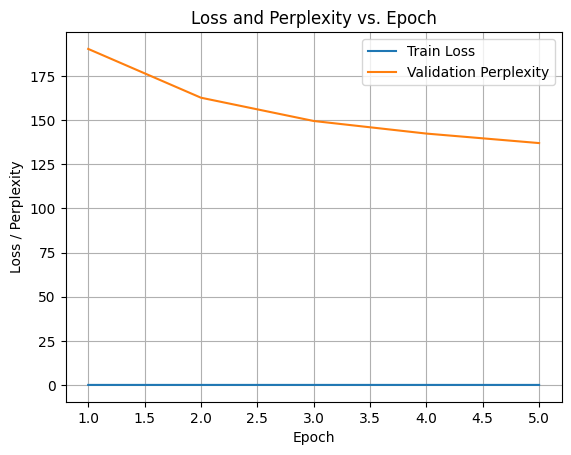

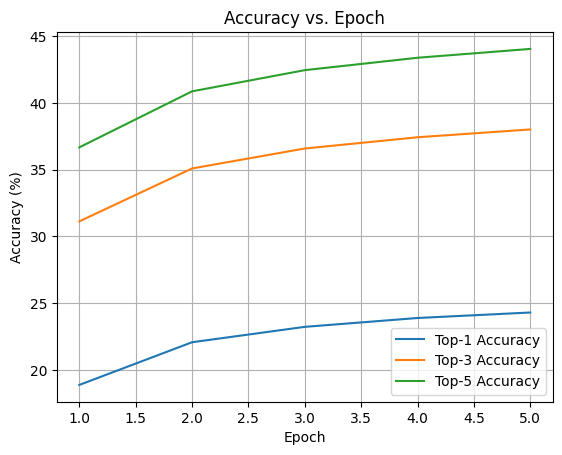

,Epoch,Train Loss,Val Perplexity,Top-1 Acc,Top-3 Acc,Top-5 Acc
0,1,0.014884,190.374095,18.873072,31.125051,36.671548
1,2,0.014224,162.739333,22.070800,35.090447,40.868170
2,3,0.014036,149.550369,23.223464,36.585893,42.455307
3,4,0.013548,142.413302,23.886961,37.427224,43.384250
4,5,0.013425,137.028412,24.298510,38.013019,44.046278


In [13]:

# Training loop with metric tracking
train_losses = []
val_losses = []
top1_accuracies = []
top3_accuracies = []
top5_accuracies = []

for epoch in range(1, EPOCHS+1):
    model = transformer_model
    optimizer = transformer_optimizer
    
    model.train()
    total_loss = 0.0
    correct_top1 = 0
    correct_top3 = 0
    correct_top5 = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader, start=1):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)  # [batch, vocab_size]
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Accuracy computations
        _, pred = outputs.topk(5, dim=1)
        targets = targets.view(-1, 1)
        correct = pred.eq(targets)
        correct_top1 += correct[:, :1].sum().item()
        correct_top3 += correct[:, :3].sum().item()
        correct_top5 += correct[:, :5].sum().item()
        total += targets.size(0)

        if batch_idx % log_interval == 0:
            avg_loss = total_loss / log_interval
            print(f"Epoch {epoch} | Batch {batch_idx}/{len(train_loader)} | Avg Loss: {avg_loss:.4f}")
            total_loss = 0.0

    epoch_loss = total_loss / len(train_loader)
    train_losses.append(epoch_loss)
    top1_accuracies.append(100. * correct_top1 / total)
    top3_accuracies.append(100. * correct_top3 / total)
    top5_accuracies.append(100. * correct_top5 / total)

    val_ppl = evaluate_perplexity(model, val_loader)
    val_losses.append(val_ppl)
    print(f"Epoch {epoch} completed. Validation perplexity: {val_ppl:.3f}")

# Plotting Loss
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Loss / Perplexity")
plt.title("Loss and Perplexity vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Accuracy
plt.figure()
plt.plot(range(1, EPOCHS+1), top1_accuracies, label="Top-1 Accuracy")
plt.plot(range(1, EPOCHS+1), top3_accuracies, label="Top-3 Accuracy")
plt.plot(range(1, EPOCHS+1), top5_accuracies, label="Top-5 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Results Table
import pandas as pd
results_df = pd.DataFrame({
    "Epoch": list(range(1, EPOCHS+1)),
    "Train Loss": train_losses,
    "Val Perplexity": val_losses,
    "Top-1 Acc": top1_accuracies,
    "Top-3 Acc": top3_accuracies,
    "Top-5 Acc": top5_accuracies
})
display(results_df)


# Analysis and Comparison

In [14]:
import numpy as np

# Put models in evaluation mode
baseline_model.eval()
transformer_model.eval()

# Compute Test Perplexity
test_ppl_baseline = evaluate_perplexity(baseline_model, test_loader)
test_ppl_transformer = evaluate_perplexity(transformer_model, test_loader)
print(f"Baseline Model Test Perplexity: {test_ppl_baseline:.3f}")
print(f"Transformer Model Test Perplexity: {test_ppl_transformer:.3f}")

# Compute Top-1, Top-3, Top-5 accuracies on test set
top1_correct_baseline = top3_correct_baseline = top5_correct_baseline = 0
top1_correct_transformer = top3_correct_transformer = top5_correct_transformer = 0
total_samples = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Baseline predictions
        logits_b = baseline_model(inputs)            # [batch, vocab_size]
        # Transformer predictions
        logits_t = transformer_model(inputs)         # [batch, vocab_size]
        # Get top-5 predictions for each sample
        top5_b = torch.topk(logits_b, k=5, dim=1).indices  # [batch, 5]
        top5_t = torch.topk(logits_t, k=5, dim=1).indices  # [batch, 5]
        # Compare to targets
        for i in range(targets.size(0)):
            target = targets[i].item()
            pred5_b = top5_b[i].tolist()
            pred5_t = top5_t[i].tolist()
            # Baseline
            if target == pred5_b[0]:
                top1_correct_baseline += 1
            if target in pred5_b[:3]:
                top3_correct_baseline += 1
            if target in pred5_b:
                top5_correct_baseline += 1
            # Transformer
            if target == pred5_t[0]:
                top1_correct_transformer += 1
            if target in pred5_t[:3]:
                top3_correct_transformer += 1
            if target in pred5_t:
                top5_correct_transformer += 1
        total_samples += targets.size(0)

# Calculate accuracies
baseline_top1 = top1_correct_baseline / total_samples * 100
baseline_top3 = top3_correct_baseline / total_samples * 100
baseline_top5 = top5_correct_baseline / total_samples * 100
transformer_top1 = top1_correct_transformer / total_samples * 100
transformer_top3 = top3_correct_transformer / total_samples * 100
transformer_top5 = top5_correct_transformer / total_samples * 100

print(f"Baseline Top-1 Accuracy: {baseline_top1:.2f}%")
print(f"Baseline Top-3 Accuracy: {baseline_top3:.2f}%")
print(f"Baseline Top-5 Accuracy: {baseline_top5:.2f}%")
print(f"Transformer Top-1 Accuracy: {transformer_top1:.2f}%")
print(f"Transformer Top-3 Accuracy: {transformer_top3:.2f}%")
print(f"Transformer Top-5 Accuracy: {transformer_top5:.2f}%")

# Measure average inference time per prediction
import time
def average_inference_time(model, device, trials=100):
    # Generate a random batch of size 1 (single example) for timing
    sample_input = torch.randint(0, vocab_size, (1, 8), dtype=torch.long).to(device)
    # Warm-up
    model(sample_input)
    torch.cuda.synchronize(device) if device.type == 'cuda' else None
    start = time.time()
    for _ in range(trials):
        model(sample_input)
    # If GPU, synchronize to wait for all ops to finish
    torch.cuda.synchronize(device) if device.type == 'cuda' else None
    end = time.time()
    avg_time = (end - start) / trials
    return avg_time

avg_time_baseline = average_inference_time(baseline_model, device)
avg_time_transformer = average_inference_time(transformer_model, device)
print(f"Baseline average inference time (per sequence): {avg_time_baseline*1000:.3f} ms")
print(f"Transformer average inference time (per sequence): {avg_time_transformer*1000:.3f} ms")

# Calculate model size (number of parameters)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

baseline_params = count_parameters(baseline_model)
transformer_params = count_parameters(transformer_model)
print(f"Baseline Model Size: {baseline_params} parameters")
print(f"Transformer Model Size: {transformer_params} parameters")


Baseline Model Test Perplexity: 209.452
Transformer Model Test Perplexity: 134.040
Baseline Top-1 Accuracy: 23.34%
Baseline Top-3 Accuracy: 35.03%
Baseline Top-5 Accuracy: 39.99%
Transformer Top-1 Accuracy: 23.76%
Transformer Top-3 Accuracy: 37.75%
Transformer Top-5 Accuracy: 43.54%
Baseline average inference time (per sequence): 0.113 ms
Transformer average inference time (per sequence): 0.694 ms
Baseline Model Size: 2865296 parameters
Transformer Model Size: 2966544 parameters


In [15]:
import pandas as pd

# Create results in dictionary format
comparison_results = {
    "Metric": [
        "Test Perplexity",
        "Top-1 Accuracy (%)",
        "Top-3 Accuracy (%)",
        "Top-5 Accuracy (%)",
        "Avg Inference Time (ms)",
        "Model Size (# Params)"
    ],
    "Baseline Model": [
        round(test_ppl_baseline, 3),
        round(baseline_top1, 2),
        round(baseline_top3, 2),
        round(baseline_top5, 2),
        round(avg_time_baseline * 1000, 3),
        baseline_params
    ],
    "Transformer Model": [
        round(test_ppl_transformer, 3),
        round(transformer_top1, 2),
        round(transformer_top3, 2),
        round(transformer_top5, 2),
        round(avg_time_transformer * 1000, 3),
        transformer_params
    ]
}

comparison_df = pd.DataFrame(comparison_results)
comparison_df

,Metric,Baseline Model,Transformer Model
0,Test Perplexity,209.452,134.040
1,Top-1 Accuracy (%),23.340,23.760
2,Top-3 Accuracy (%),35.030,37.750
3,Top-5 Accuracy (%),39.990,43.540
4,Avg Inference Time (ms),0.113,0.694
5,Model Size (# Params),2865296.000,2966544.000


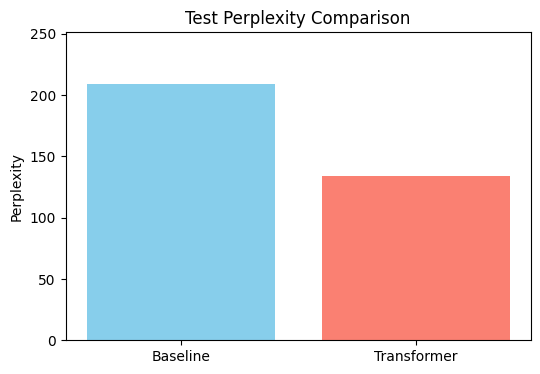

In [16]:
import matplotlib.pyplot as plt

models = ['Baseline', 'Transformer']
perplexities = [test_ppl_baseline, test_ppl_transformer]

plt.figure(figsize=(6,4))
plt.bar(models, perplexities, color=['skyblue', 'salmon'])
plt.title('Test Perplexity Comparison')
plt.ylabel('Perplexity')
plt.ylim(0, max(perplexities) * 1.2)
plt.show()


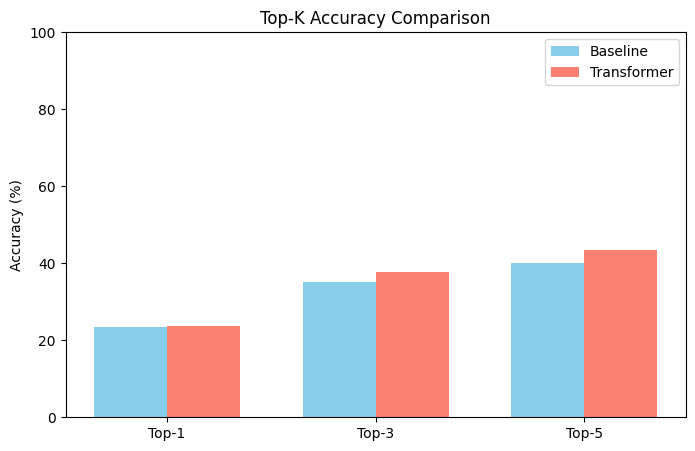

In [17]:
top_k = ['Top-1', 'Top-3', 'Top-5']
baseline_acc = [baseline_top1, baseline_top3, baseline_top5]
transformer_acc = [transformer_top1, transformer_top3, transformer_top5]

x = np.arange(len(top_k))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, baseline_acc, width, label='Baseline', color='skyblue')
plt.bar(x + width/2, transformer_acc, width, label='Transformer', color='salmon')

plt.xticks(x, top_k)
plt.ylabel('Accuracy (%)')
plt.title('Top-K Accuracy Comparison')
plt.legend()
plt.ylim(0, 100)
plt.show()


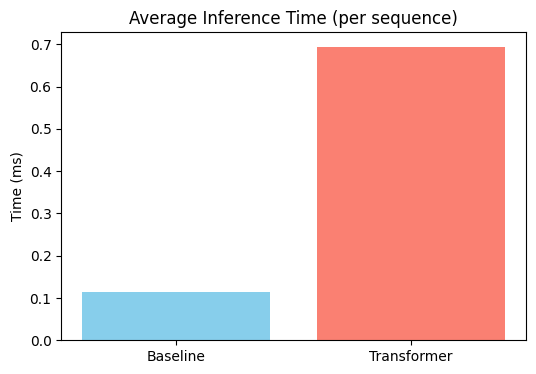

In [18]:
inference_times = [avg_time_baseline * 1000, avg_time_transformer * 1000]  # in ms

plt.figure(figsize=(6,4))
plt.bar(models, inference_times, color=['skyblue', 'salmon'])
plt.title('Average Inference Time (per sequence)')
plt.ylabel('Time (ms)')
plt.show()


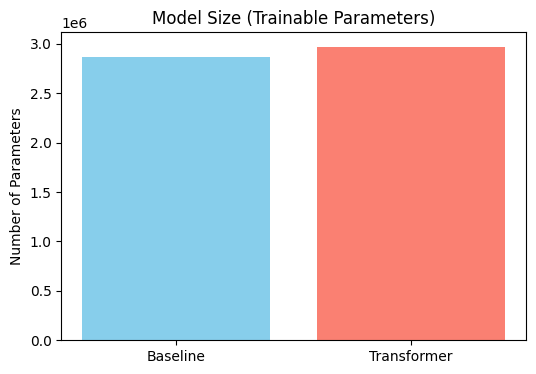

In [19]:
model_sizes = [baseline_params, transformer_params]

plt.figure(figsize=(6,4))
plt.bar(models, model_sizes, color=['skyblue', 'salmon'])
plt.title('Model Size (Trainable Parameters)')
plt.ylabel('Number of Parameters')
plt.show()


In [20]:
torch.save(baseline_model.state_dict(), "baseline_model.pth")
torch.save(transformer_model.state_dict(), "transformer_model.pth")
